In [2]:
import os, random, shutil

def randomize_datasets(pvTrain, pvTest, pvValid, path, typeML):
    
    totalFiles = len(next(os.walk(path+typeML))[2])
    trainMove = 0
    testMove = 0
    validMove = 0
    
    
    # n%20 < 16 put in folder train
    # elif x%20 < 19 put in folder test
    # else (x%20 == 19) put in folder verify
    
    print ("Moving {0} files...".format(totalFiles))
    x = 0
    while (x!=totalFiles):
        random.seed();
        for root, dirs, files in os.walk(path+typeML):
            for name in files:
                chance = random.uniform(0,99)
                rfile=os.path.join(root, name)    

                if (chance % 100 < pvValid):
                    shutil.move(rfile, path+'/valid/'+typeML+'/')
                    validMove = validMove + 1
                elif (chance % 100 < pvValid + pvTest):
                    shutil.move(rfile, path+'/test/'+typeML+'/')
                    testMove = testMove + 1
                else:
                    shutil.move(rfile, path+'/train/'+typeML+'/')
                    trainMove = trainMove + 1
                x = x + 1
        
    print ("Moved {0} to train!".format(trainMove))
    print ("Moved {0} to test!".format(testMove))
    print ("Moved {0} to valid!".format(validMove))
 


    
randomize_datasets(80, 15, 5, '/home/aashinshazar/beta/cookiesinthejar/', 'bad')
randomize_datasets(80, 15, 5, '/home/aashinshazar/beta/cookiesinthejar/', 'good')


Moving 326 files...
Moved 251 to train!
Moved 63 to test!
Moved 12 to valid!
Moving 253 files...
Moved 199 to train!
Moved 37 to test!
Moved 17 to valid!


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

bigPath = '/home/aashinshazar/beta/cookiesinthejar/'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    part_files = np.array(data['filenames'])
    part_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return part_files, part_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(bigPath + 'train')
test_files, test_targets = load_dataset(bigPath +'test')
valid_files, valid_targets = load_dataset(bigPath +'valid')

print('There are %d training part images.' % len(train_files))
print('There are %d validation part images.' % len(valid_files))
print('There are %d test part images.'% len(test_files))

Using TensorFlow backend.


There are 1440 training part images.
There are 77 validation part images.
There are 275 test part images.


In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 275/275 [00:01<00:00, 206.24it/s]


In [3]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils import multi_gpu_model
import tensorflow as tf

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
dropout_1 (Dropout)          (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxP

In [4]:
from keras.callbacks import ModelCheckpoint
import time

import matplotlib.pyplot as plt
import numpy

epochs = 100
batch_size=20

bestModelSavedName = "finalBench.hdf5"

checkpointer = ModelCheckpoint(filepath=bestModelSavedName, 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets), 
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 1440 samples, validate on 77 samples
Epoch 1/100
 - 4s - loss: 0.6806 - acc: 0.5958 - val_loss: 0.6846 - val_acc: 0.5844

Epoch 00001: val_loss improved from inf to 0.68463, saving model to finalBench.hdf5
Epoch 2/100
 - 2s - loss: 0.6617 - acc: 0.6059 - val_loss: 0.6814 - val_acc: 0.5844

Epoch 00002: val_loss improved from 0.68463 to 0.68144, saving model to finalBench.hdf5
Epoch 3/100
 - 2s - loss: 0.6562 - acc: 0.6260 - val_loss: 0.6789 - val_acc: 0.5844

Epoch 00003: val_loss improved from 0.68144 to 0.67892, saving model to finalBench.hdf5
Epoch 4/100
 - 2s - loss: 0.6443 - acc: 0.6354 - val_loss: 0.6816 - val_acc: 0.6299

Epoch 00004: val_loss did not improve from 0.67892
Epoch 5/100
 - 2s - loss: 0.6385 - acc: 0.6573 - val_loss: 0.6740 - val_acc: 0.5974

Epoch 00005: val_loss improved from 0.67892 to 0.67401, saving model to finalBench.hdf5
Epoch 6/100
 - 2s - loss: 0.6223 - acc: 0.6670 - val_loss: 0.6691 - val_acc: 0.597

 - 2s - loss: 0.5182 - acc: 0.7639 - val_loss: 0.6687 - val_acc: 0.5974

Epoch 00056: val_loss did not improve from 0.65819
Epoch 57/100
 - 2s - loss: 0.5168 - acc: 0.7514 - val_loss: 0.6674 - val_acc: 0.5779

Epoch 00057: val_loss did not improve from 0.65819
Epoch 58/100
 - 2s - loss: 0.5155 - acc: 0.7628 - val_loss: 0.6903 - val_acc: 0.5195

Epoch 00058: val_loss did not improve from 0.65819
Epoch 59/100
 - 2s - loss: 0.5211 - acc: 0.7615 - val_loss: 0.6782 - val_acc: 0.5519

Epoch 00059: val_loss did not improve from 0.65819
Epoch 60/100
 - 2s - loss: 0.5088 - acc: 0.7649 - val_loss: 0.6838 - val_acc: 0.5325

Epoch 00060: val_loss did not improve from 0.65819
Epoch 61/100
 - 2s - loss: 0.5127 - acc: 0.7663 - val_loss: 0.6775 - val_acc: 0.5325

Epoch 00061: val_loss did not improve from 0.65819
Epoch 62/100
 - 2s - loss: 0.5088 - acc: 0.7625 - val_loss: 0.6859 - val_acc: 0.5714

Epoch 00062: val_loss did not improve from 0.65819
Epoch 63/100
 - 2s - loss: 0.5044 - acc: 0.7635 - val_

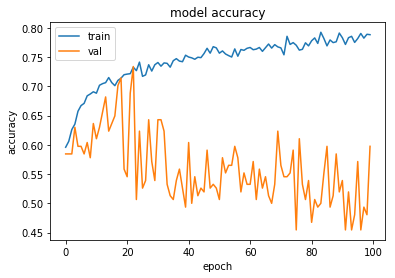

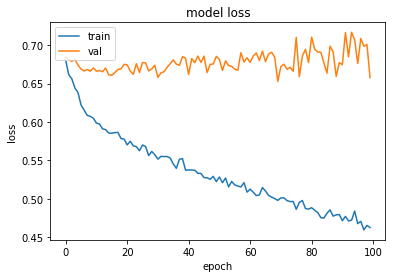

In [5]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [6]:
from sklearn.metrics import f1_score
import pandas as pd

model.load_weights('/home/aashinshazar/' + bestModelSavedName)

# get index of predicted part for each image in the test image set
part_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(part_predictions)==np.argmax(test_targets, axis=1))/len(part_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

print ("Fscore:", f1_score(np.argmax(test_targets, axis=1), part_predictions, average=None) )

y_actu = pd.Series(np.argmax(test_targets, axis=1), name='Actual')
y_pred = pd.Series(part_predictions, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

Test accuracy: 62.1818%
Fscore: [0.60902256 0.63380282]
Predicted    0    1  All
Actual                  
0           81   24  105
1           80   90  170
All        161  114  275
